In [11]:
# Imports
from loader import load_log_file
from plt_style import set_style
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
# CONFIG
COMMUNICATION_TYPE = "discrete"
SEED = 0


set_style()

In [13]:
# Load data
df = load_log_file(COMMUNICATION_TYPE, SEED)

Text(0.5, 1.0, 'Correlation: Vocabulary Expansion vs. Task Reward')

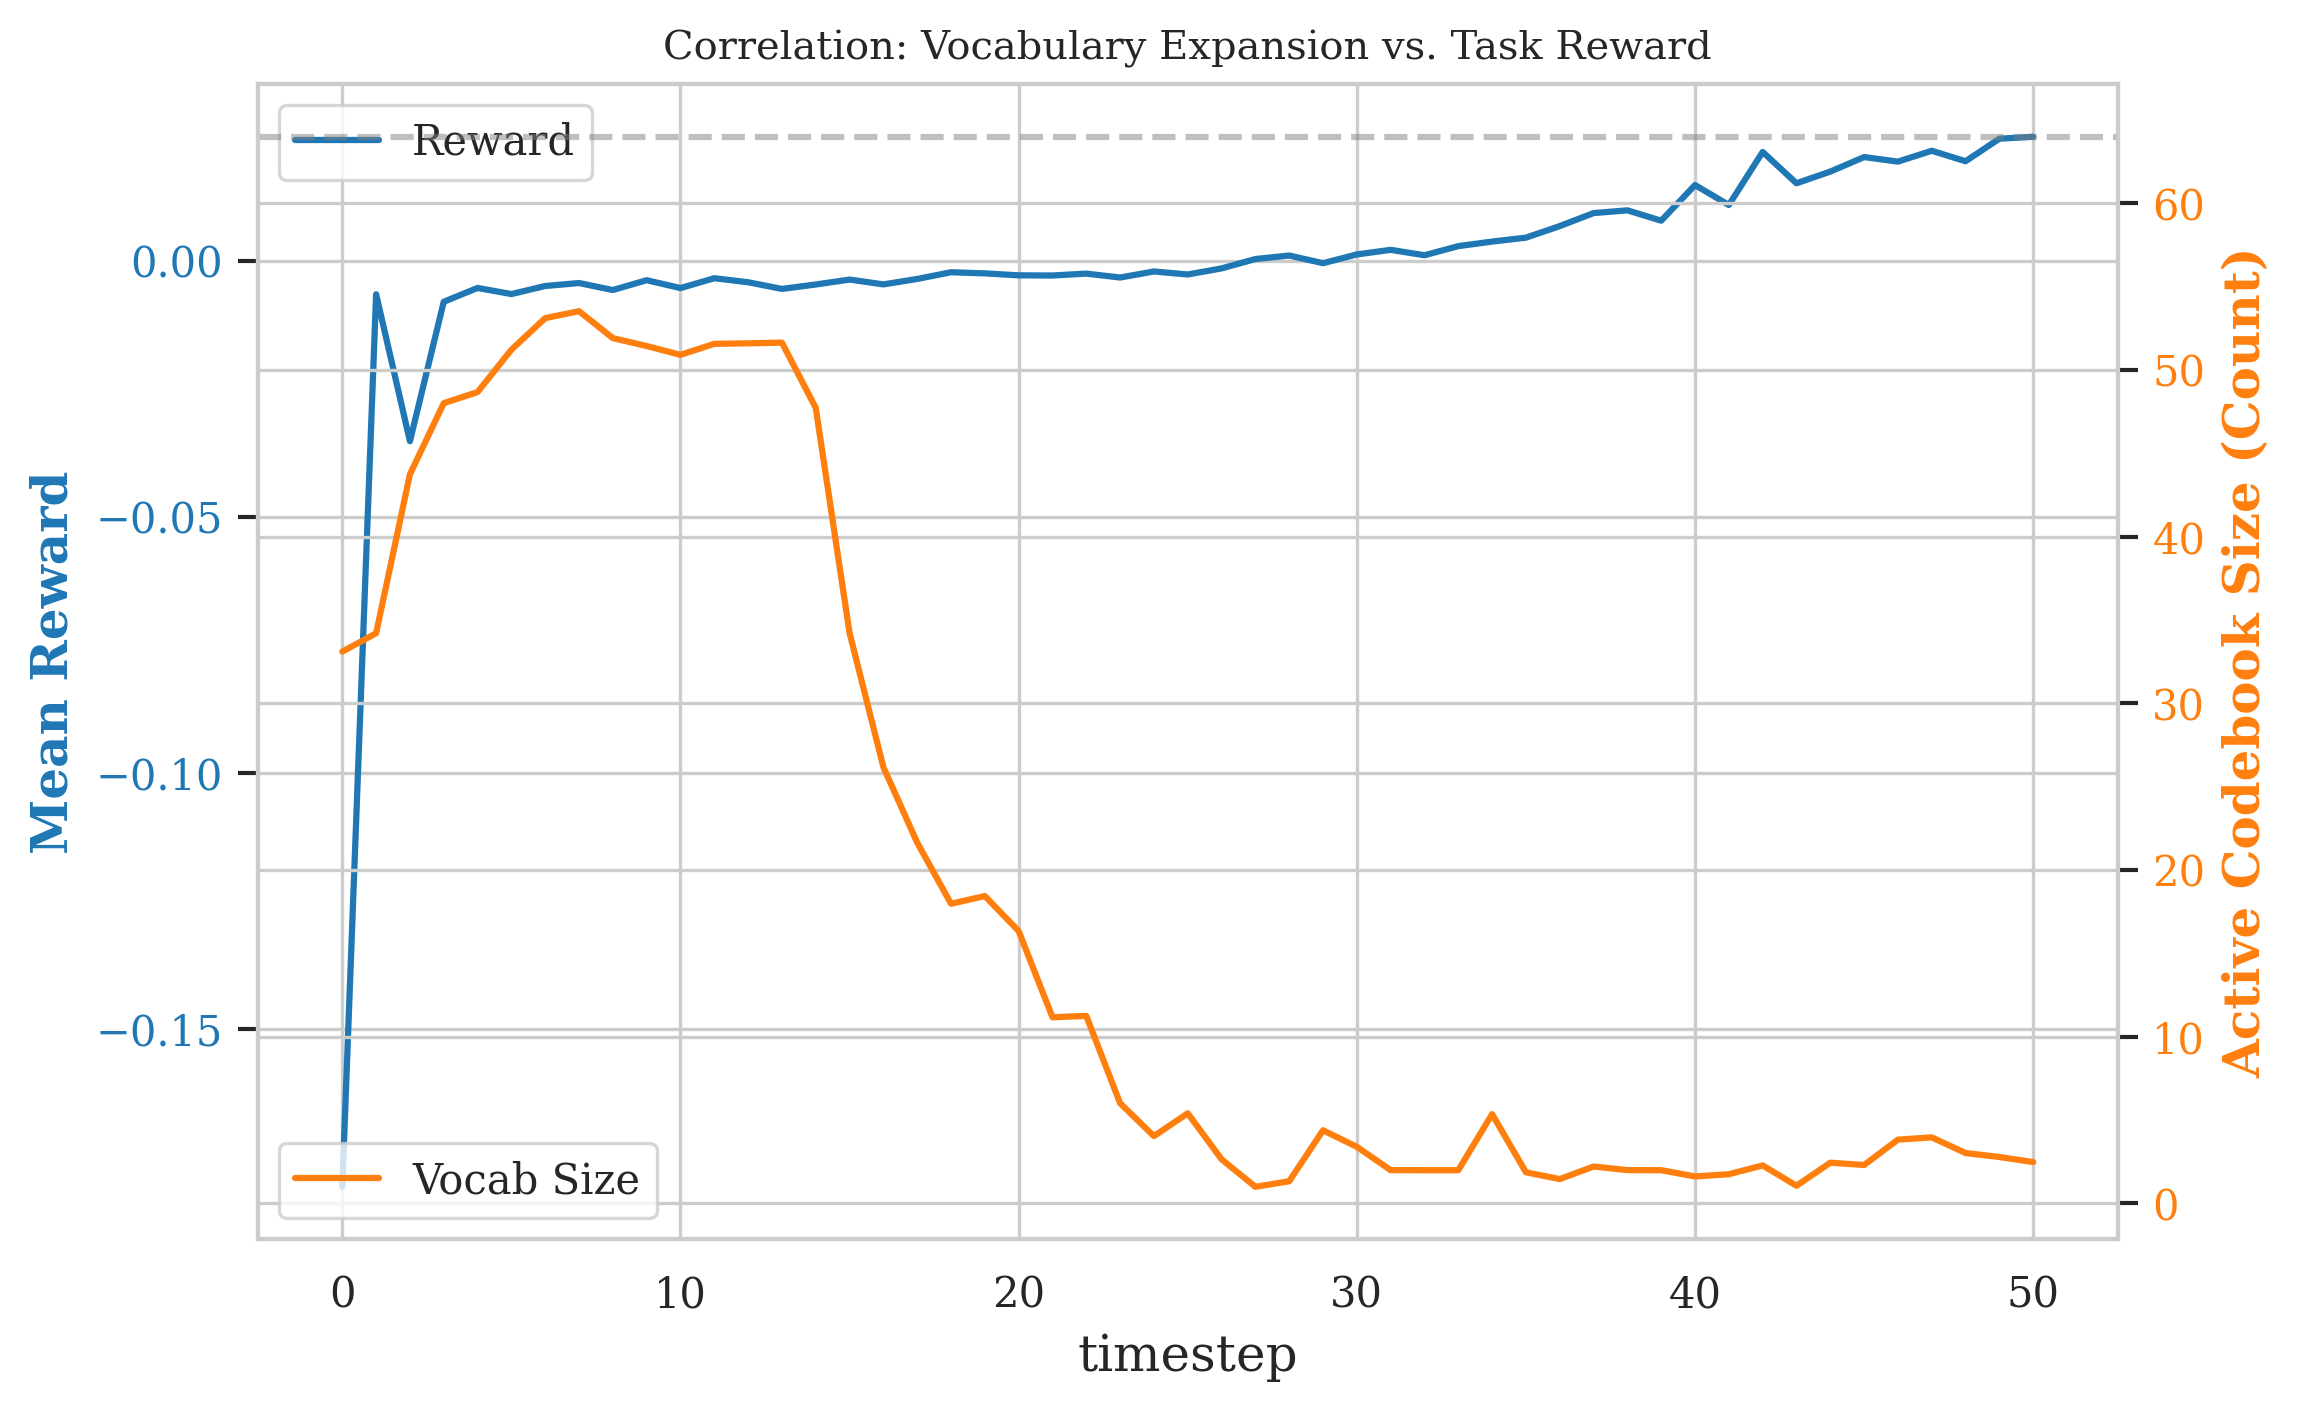

In [14]:
# Reward vs Active Codebook Usage over time
fig, ax1 = plt.subplots(figsize=(8, 5))

sns.lineplot(data=df, x="timestep", y="reward_mean", ax=ax1, color="tab:blue", label="Reward")
ax1.set_ylabel("Mean Reward", color="tab:blue", fontweight='bold')
ax1.tick_params(axis='y', labelcolor="tab:blue")

ax2 = ax1.twinx()
sns.lineplot(data=df, x="timestep", y="communication_active_codebook_usage", ax=ax2, color="tab:orange", label="Vocab Size")
ax2.set_ylabel("Active Codebook Size (Count)", color="tab:orange", fontweight='bold')
ax2.tick_params(axis='y', labelcolor="tab:orange")
ax2.axhline(64, linestyle="--", color="gray", alpha=0.5, label="Max Vocab")

plt.title("Correlation: Vocabulary Expansion vs. Task Reward")

Text(0.5, 1.0, 'Language Crystallization: Complexity vs. Stability')

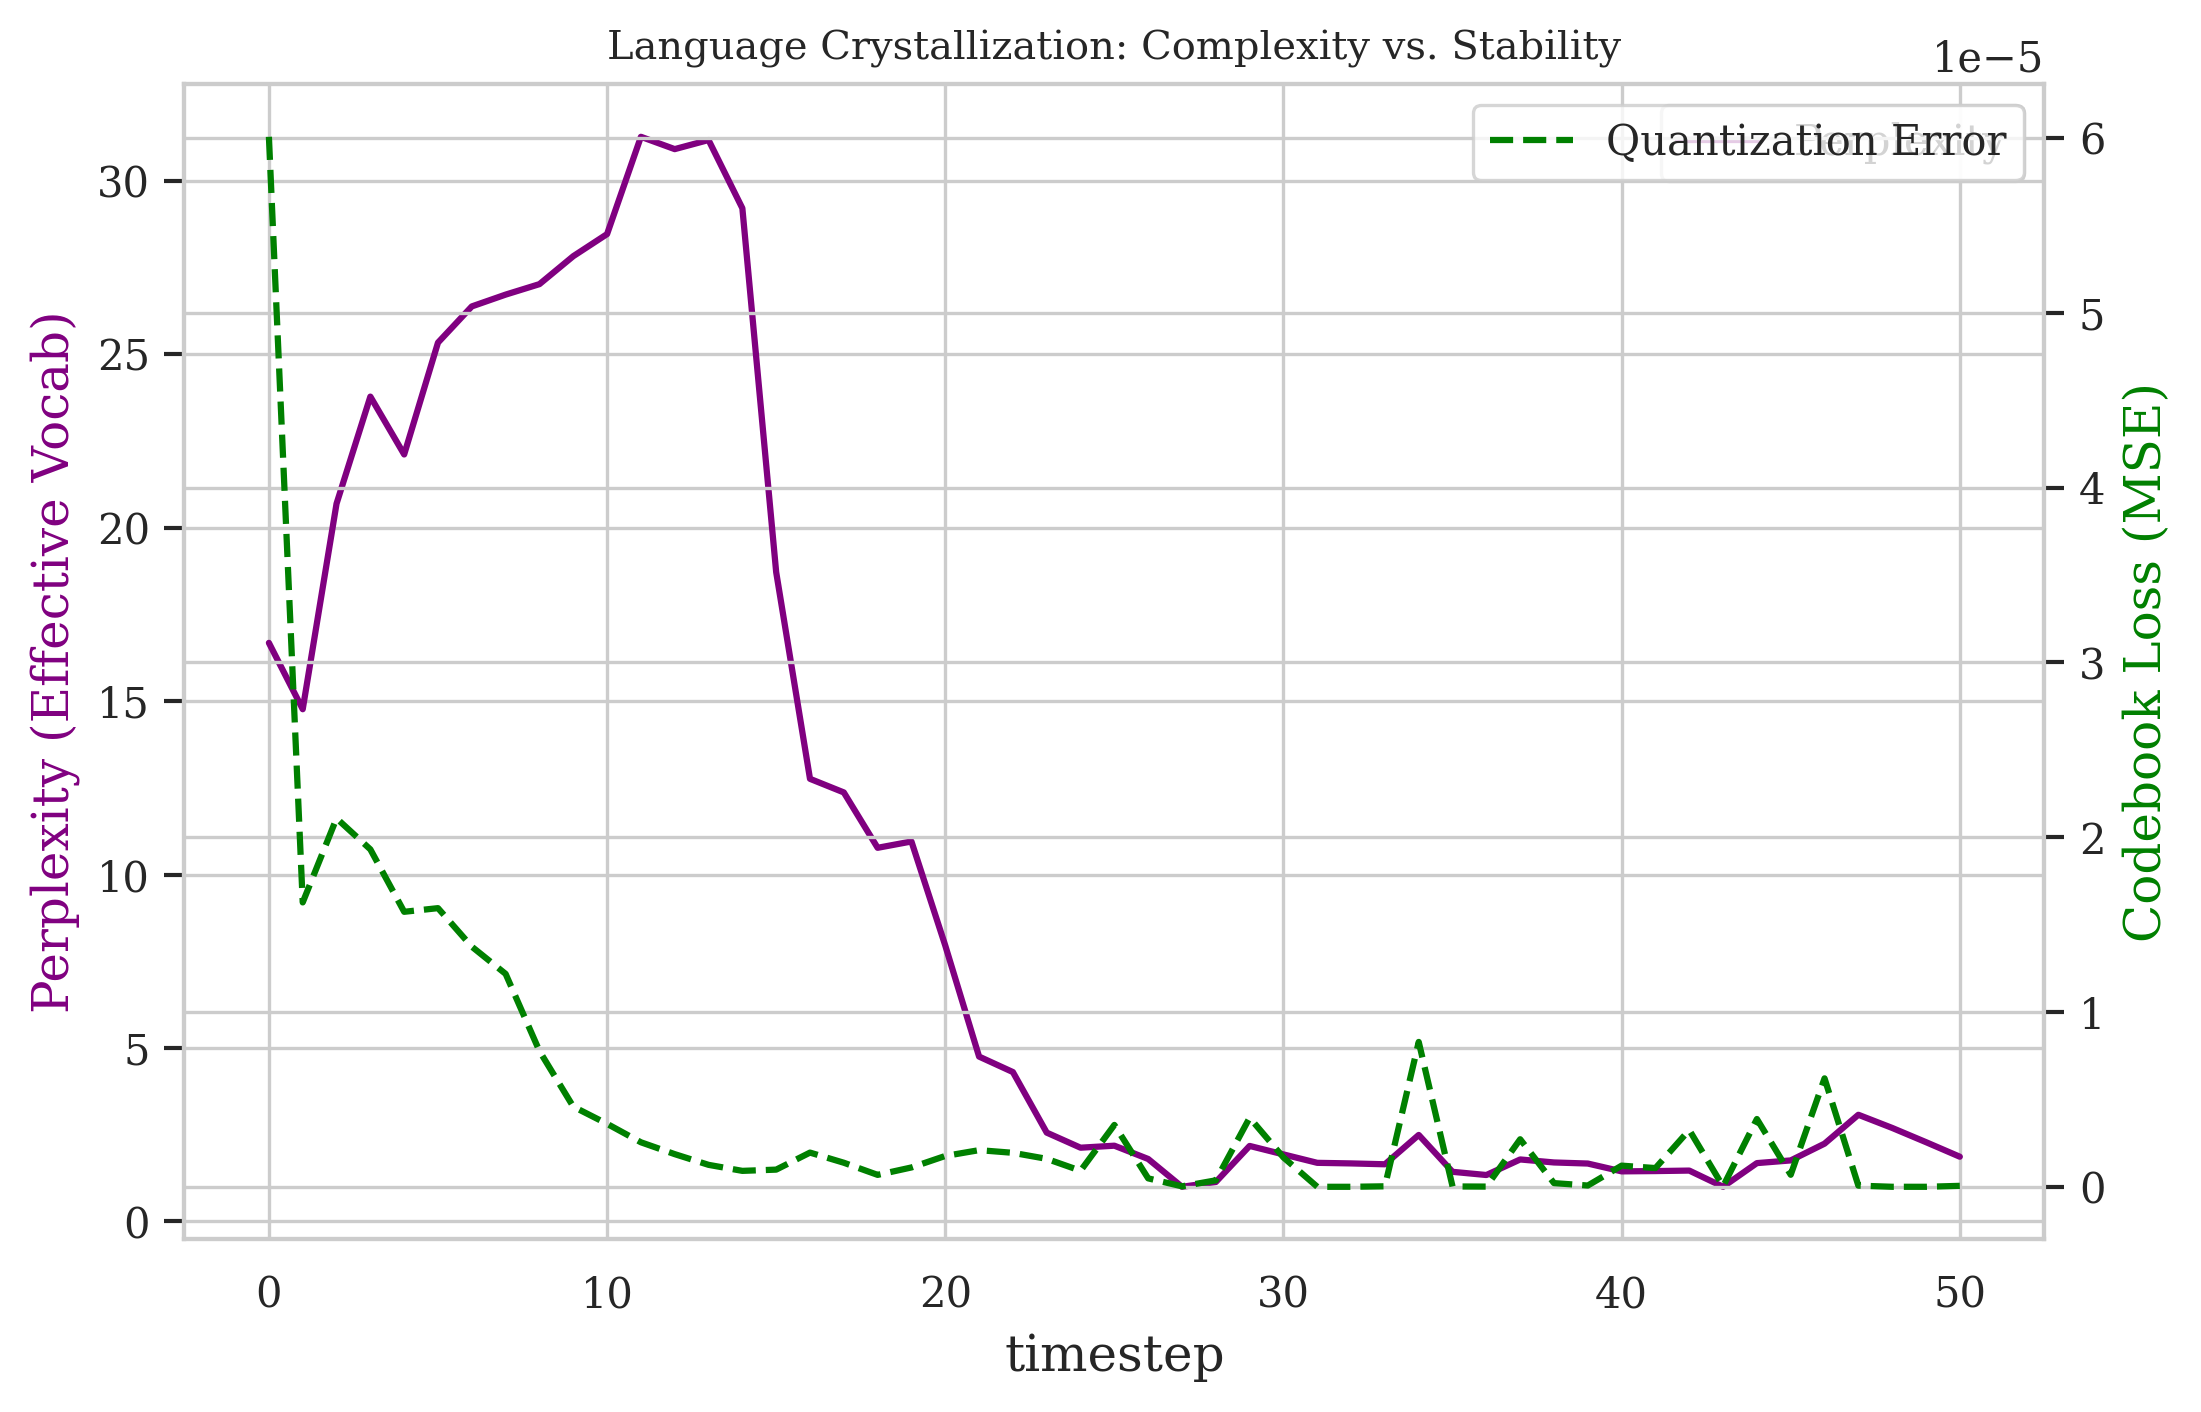

In [15]:
# VQ Loss vs Perplexity over time
fig, ax1 = plt.subplots(figsize=(8, 5))

sns.lineplot(data=df, x="timestep", y="communication_perplexity_mean", ax=ax1, color="purple", label="Perplexity")
ax1.set_ylabel("Perplexity (Effective Vocab)", color="purple")

ax2 = ax1.twinx()
sns.lineplot(data=df, x="timestep", y="codebook_loss", ax=ax2, color="green", linestyle="--", label="Quantization Error")
ax2.set_ylabel("Codebook Loss (MSE)", color="green")

plt.title("Language Crystallization: Complexity vs. Stability")

Text(0.5, 1.0, 'Training Stability Analysis (Log Scale)')

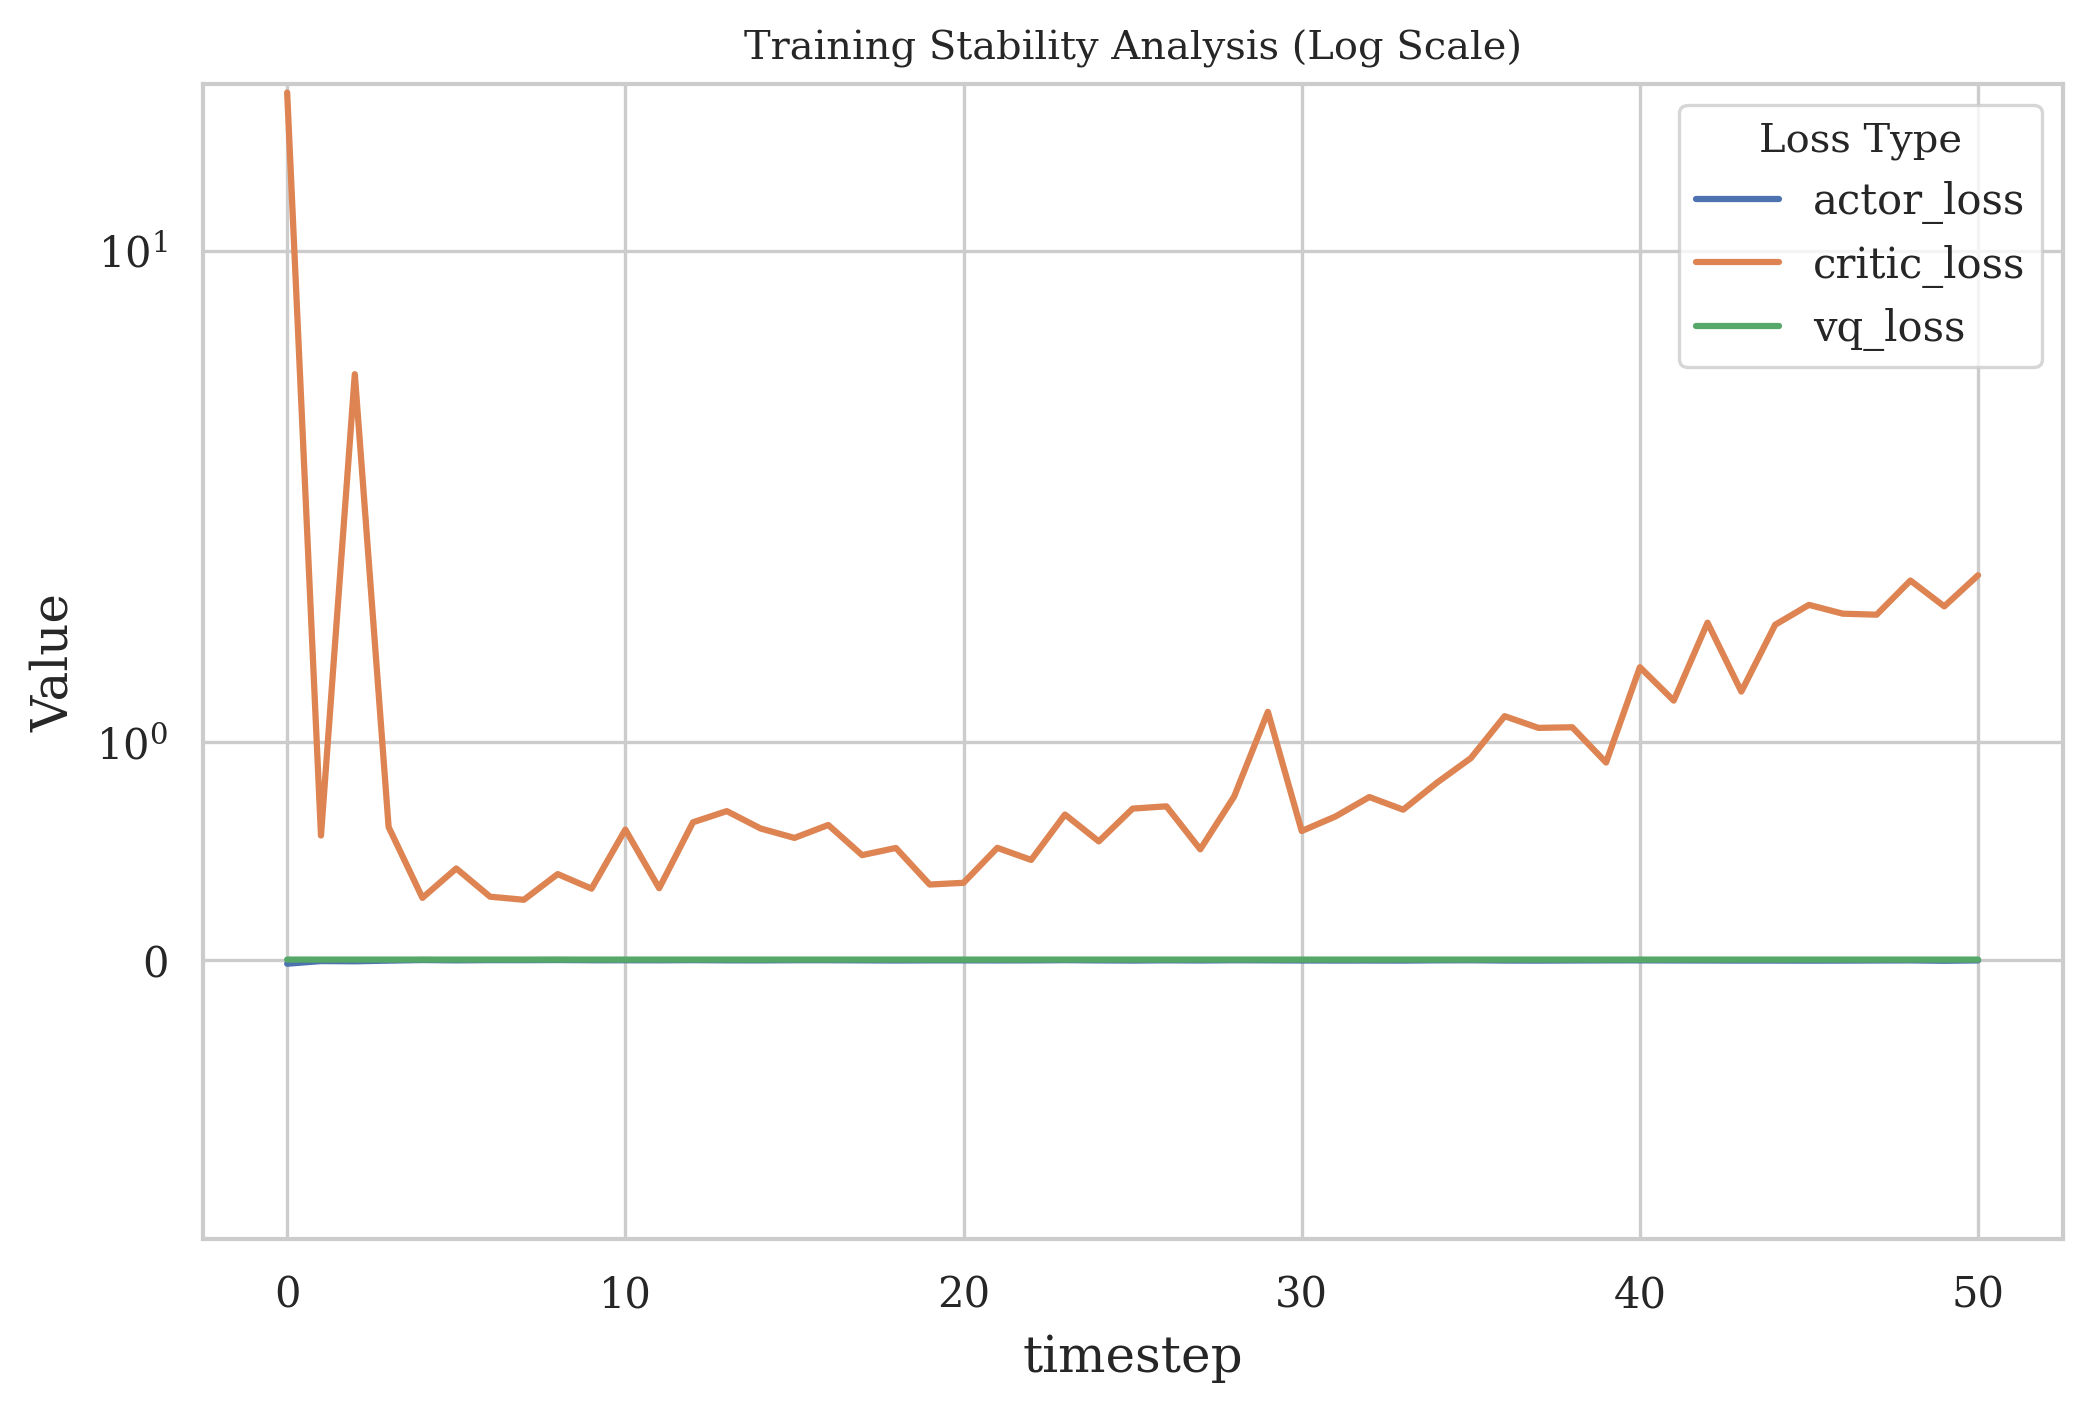

In [16]:
# Loss over time
loss_df = df.melt(id_vars=["timestep"], value_vars=["actor_loss", "critic_loss", "vq_loss"], 
                  var_name="Loss Type", value_name="Value")

plt.figure(figsize=(8, 5))
sns.lineplot(data=loss_df, x="timestep", y="Value", hue="Loss Type")
plt.yscale("symlog")
plt.title("Training Stability Analysis (Log Scale)")